<a href="https://colab.research.google.com/github/akimi-yano/Lung_X-Ray_Classification/blob/main/Lung_X_Ray_Classification_COVID%2CPneumonia%2CHealthyLung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Overview</h1>

Chest X-Rays have had a massive role in detecting Covid-19 in an individual. Considering how the disease has affected us, we will create a Deep-Learning model as the first level of self-diagnosis. It will classify the Chest XRay image into COVID, Pneumonia, or a healthy lung (i.e., no diseases found).

<h1>Datasets</h1>

We are combining the datasets from multiple locations. You can find the individual datasets here:

1. Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification", Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2
2. [COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset](https://www.kaggle.com/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset)
3. * M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, "Can AI help in screening Viral and COVID-19 pneumonia?" IEEE Access, Vol. 8, 2020, pp. 132665 - 132676. [Paper link](https://ieeexplore.ieee.org/document/9144185)
   * Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. [Paper Link](https://doi.org/10.1016/j.compbiomed.2021.104319)

We have combined and prepared the dataset already. You can download it from the following dropbox link: https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1

Dataset contains 3 folders, namely:
* <b>Covid</b>: This folder contains lung x-ray images with covid-19 disease
* <b>Pneumonia</b>: This folder contains lung x-ray images with pneumonia disease
* <b>Normal</b>: This folder contains normal functioning and healthy lung x-ray images


In [5]:
# Checking the GPU information

!nvidia-smi

Sun Jan 26 20:56:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Importing libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model

import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Checking the tensorflow version

tf.__version__

'2.17.1'

In [8]:
# Downloading the dataset with COVID-19, Pneumonia, and Normal images

!wget https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1 -O 'archive.zip'

--2025-01-26 20:56:10--  https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/z0a4ackpdc1ukixx227u6/Dataset.zip?rlkey=i250de6auumctxrrqnnqo1o10&dl=1 [following]
--2025-01-26 20:56:10--  https://www.dropbox.com/scl/fi/z0a4ackpdc1ukixx227u6/Dataset.zip?rlkey=i250de6auumctxrrqnnqo1o10&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7233d9c1f6755d011a8a532d83.dl.dropboxusercontent.com/cd/0/inline/Ci_wcPSZD7W1aSPqXFJzP2pWKOoJYcR6pX2fxbIYymU2J51OR0MB4PDZW7sL_LGxBFaarED6Z2Po3a6GfvE-qnFSsDcQk7deAIxevG9dzW7FtSGAGake51YnMQyS2NKACKt7yxxFxtxUCzu7AQ-JXzPT/file?dl=1# [following]
--2025-01-26 20:56:11--  https://uc7233d9c1f6755d011a8a532d83.dl.dropboxuserconte

In [9]:
# Unzipping the dataset and delete the .zip file

!unzip -q 'archive.zip'
!rm -rf 'archive.zip'

In [10]:
# Settting up batch size, random seed, and the dataset path

TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
SEED = 21
dataset_path = 'Dataset'

In [11]:
# check the file path
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")

Directory: Dataset
Directory: Dataset/val
Directory: Dataset/val/pneumonia
Directory: Dataset/val/covid
Directory: Dataset/val/normal
Directory: Dataset/train
Directory: Dataset/train/pneumonia
Directory: Dataset/train/covid
Directory: Dataset/train/normal
Directory: Dataset/test
Directory: Dataset/test/pneumonia
Directory: Dataset/test/covid
Directory: Dataset/test/normal


In [12]:
# Initialising ImageDataGenerator for data augmentation
# zca_epsilon: Epsilon for ZCA whitening. Default is 1e-6

train_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
                                  zca_epsilon = 0.0,
                                  horizontal_flip = True,
                               )

val_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
                            )

test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
                             )

In [13]:
# Taking input of the train, validation, and test images using flow_from_directory() function
# Setting the image size to (224, 224) and setting the batch size

train_datagen = train_gen.flow_from_directory(directory = dataset_path + '/train',
                                                  target_size = (224, 224),
                                                  color_mode = "rgb",
                                                  classes = None,
                                                  class_mode = "categorical",
                                                  batch_size = TRAIN_BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = SEED,
                                                  interpolation = "nearest")

val_datagen = val_gen.flow_from_directory(directory = dataset_path + '/val',
                                                target_size = (224, 224),
                                                color_mode = "rgb",
                                                classes = None,
                                                class_mode = "categorical",
                                                batch_size = VAL_BATCH_SIZE,
                                                shuffle = False,
                                                seed = SEED,
                                                interpolation = "nearest")


# For testing, we should take one input at a time. Hence, batch_size = 1

test_datagen = test_gen.flow_from_directory(directory = dataset_path + '/test',
                                            target_size = (224, 224),
                                            color_mode = "rgb",
                                            classes = None,
                                            class_mode = "categorical",
                                            batch_size = 1,
                                            shuffle = False,
                                            seed = SEED,
                                            interpolation = "nearest")

Found 11290 images belonging to 3 classes.
Found 3215 images belonging to 3 classes.
Found 1563 images belonging to 3 classes.


In [14]:
# Initialising MobileNet model and passing the imagenet weights
# Specifying classes = 1000 because the model was trained on 1000 classes
# The classes will be changed afterwards

pretrained_model = tf.keras.applications.MobileNetV3Small(weights = 'imagenet',
                                                   classes = 1000,
                                                   input_shape = (224, 224, 3),
                                                   include_top = False,
                                                   pooling = 'max')

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Printing the model summary

print(pretrained_model.summary())

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

None


In [16]:
pretrained_model.trainable = False

In [17]:
print(pretrained_model.output_shape)

(None, 576)


In [18]:
# adding custom classification layers and allowing to classify for 3 classes
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(train_datagen.num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# compile the model with adam optimizer
model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Path to save my model
model_filepath = 'best_model.keras'


# ModelCheckpoint callback will save models weight if the training accuracy of the model has increased from the previous epoch
model_save = tf.keras.callbacks.ModelCheckpoint(model_filepath,
                                                monitor = "val_accuracy",
                                                verbose = 1,
                                                save_best_only = True,
                                                save_weights_only = False,
                                                mode = "max",
                                                save_freq = "epoch")

# Adding early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                              patience = 10,
                                              mode = "max",
                                              restore_best_weights = True)

# Adding callbacks
callback = [model_save, early_stop]

In [20]:
# Printing the updated model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 1,088,627 (4.15 MB)

 Trainable params: 148,995 (582.01 KB)

 Non-trainable params: 939,632 (3.58 MB)

None


In [21]:
print(len(train_datagen))
print(len(val_datagen))
print(len(test_datagen))

177
51
1563


In [22]:
history = model.fit(train_datagen,
                    epochs = 30,
                    validation_data = val_datagen,
                    callbacks = callback)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8413 - loss: 0.4120
Epoch 1: val_accuracy improved from -inf to 0.90544, saving model to best_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 116s 560ms/step - accuracy: 0.8419 - loss: 0.4105 - val_accuracy: 0.9054 - val_loss: 0.2991
Epoch 2/30
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9267 - loss: 0.1853
Epoch 2: val_accuracy improved from 0.90544 to 0.90575, saving model to best_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 92s 504ms/step - accuracy: 0.9267 - loss: 0.1853 - val_accuracy: 0.9058 - val_loss: 0.3475
Epoch 3/30
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9480 - loss: 0.1491
Epoch 3: val_accuracy improved from 0.90575 to 0.91166, saving model to best_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 94s 512ms/step - accuracy: 0.9480 - loss: 0.1492 - val_accuracy: 0.9117 - val_loss: 0.2731
Epoch 4/30
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9417 - loss: 0.1467
Epoch 4: val_accuracy did not impr

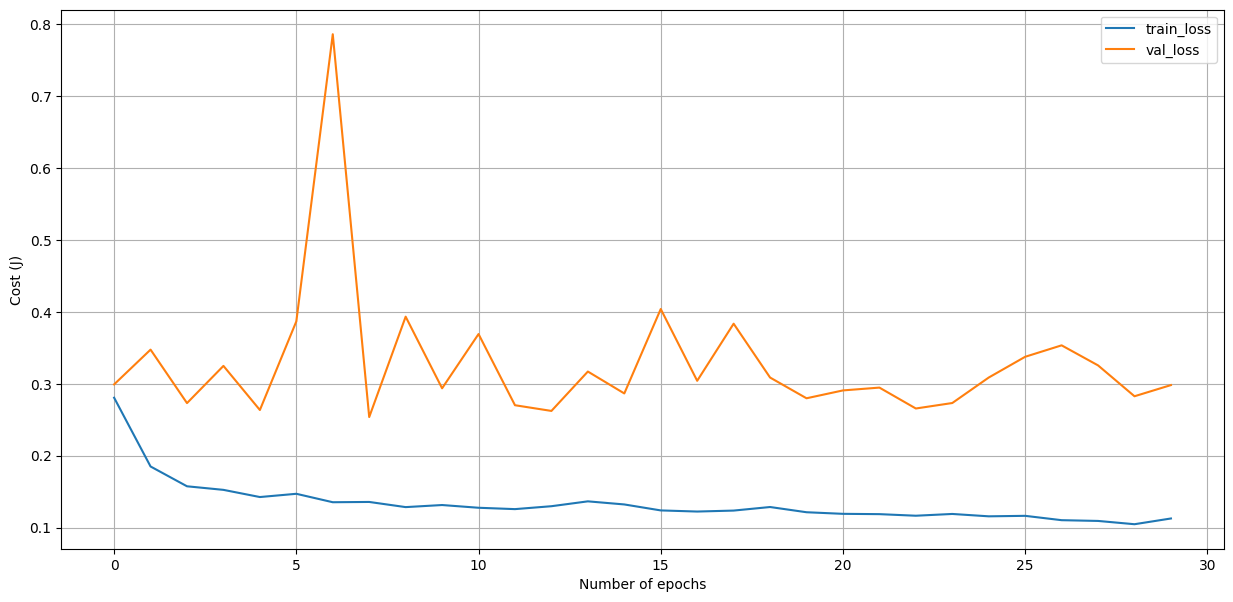

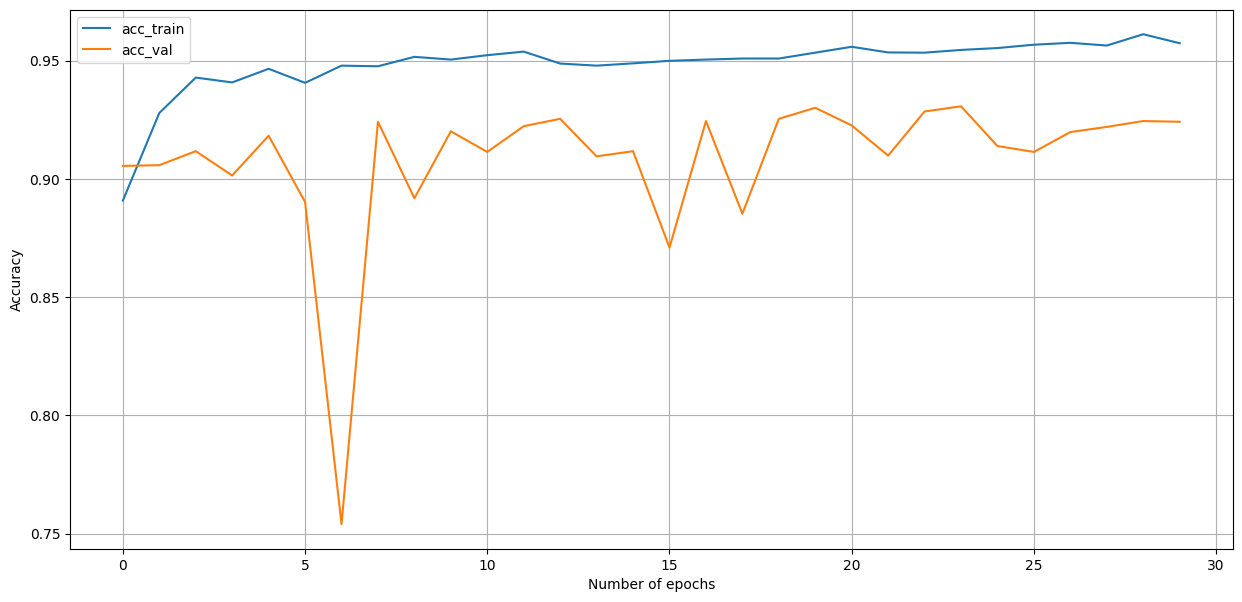

In [23]:
# Plotting the loss and accuracy graphs

import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

tr_losses = history.history['loss']
val_losses = history.history['val_loss']

tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

## Model evaluation on test set



In [24]:
# Model prediction on test set
predictions = model.predict(test_datagen,
                            verbose = 1,
                            steps = (len(test_datagen)))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step


In [25]:
# Printing predicted classes on the test dataset
predictions.squeeze().argmax(axis = -1)

array([0, 0, 0, ..., 2, 2, 2])

In [26]:
# Generating the classification report for checking the model's performance on the test set of the same dataset
classification__report = classification_report(test_datagen.classes,
                                               predictions.squeeze().argmax(axis = 1))
print(classification__report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       491
           1       0.92      0.92      0.92       545
           2       0.99      0.95      0.97       527

    accuracy                           0.94      1563
   macro avg       0.94      0.94      0.94      1563
weighted avg       0.94      0.94      0.94      1563



In [27]:
# Generating confusion matrix to see where the model is misclassifying
confusion__matrix = confusion_matrix(test_datagen.classes,
                                     predictions.squeeze().argmax(axis = 1))
print(confusion__matrix)

[[465  24   2]
 [ 38 502   5]
 [  7  18 502]]


In [28]:
# Defining a function to print a confusion matrix
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

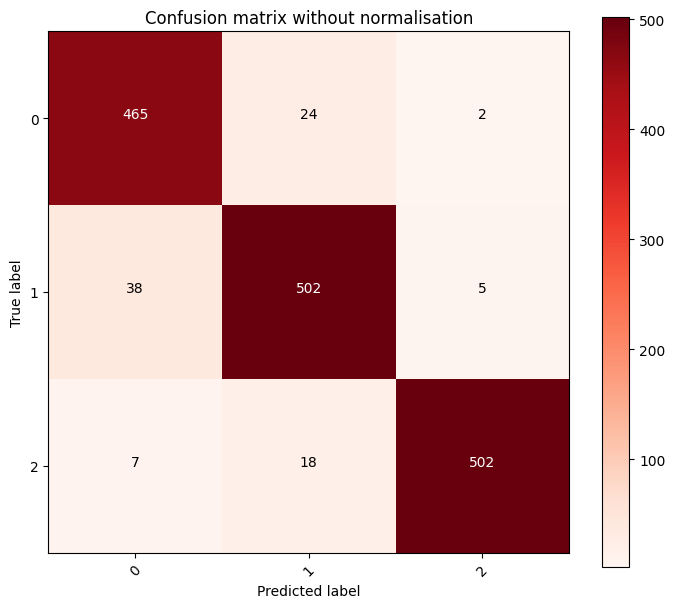

In [29]:
# Printing the confusion matrix (not normalised)
np.set_printoptions(precision = 2)
fig1 = plt.figure(figsize = (7, 6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      title = 'Confusion matrix without normalisation')
fig1.savefig('/content/cm_wo_norm.jpg')
plt.show()

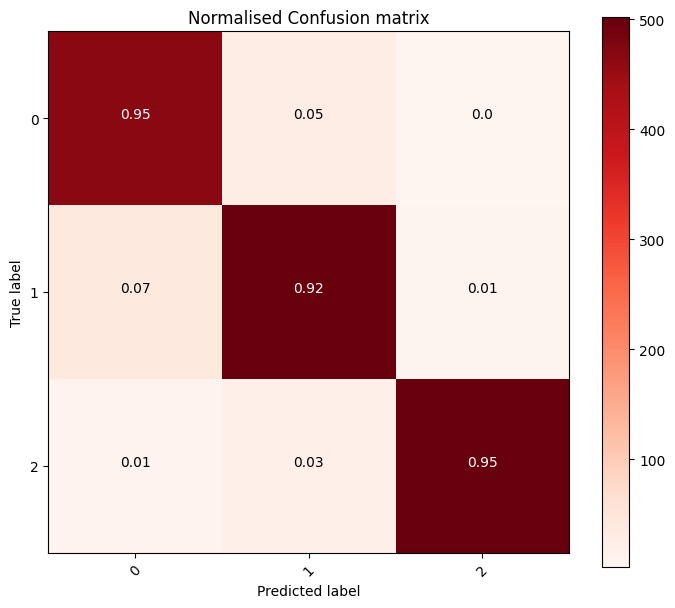

In [30]:
# Printing the confusion matrix (normalised)
np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      normalise = True,
                      title = 'Normalised Confusion matrix')
fig2.savefig('/content/cm_norm.jpg')
plt.show()